In [20]:
import os 
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Prep:----------------------------------
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/share')
today = time.strftime("%d_%b_%Y", time.gmtime())
run = '03'
locs = [#('M67','M67_run_02_cum_FFD.csv',4.0),
        ('M44','M44_run_{}_cum_FFD.csv'.format(run),0.794),
       # ('NGC_1647','NGC_1647_run_{}_cum_FFD.csv'.format(run),0.145),
        ('Pleiades','Pleiades_run_{}_cum_FFD.csv'.format(run),0.120)]
frames = []
for (key, value,age) in locs:
    df = pd.read_csv(value,
                     usecols = ['Tmax','Tmin','alpha',
                                'alpha_err','beta','beta_err',
                                'minenerg','maxenerg'],
                     )
    frames.append(df)
res = pd.concat(frames, keys=[x[2] for x in locs])
res = res.reset_index()
res = res.drop('level_1',axis=1)
res = res.rename(index=str, columns={'level_0':'age'})
ages = {4.0:'M67',0.794:'M44',0.145:'NGC_1647',0.120:'Pleiades'}
res['cluster'] = [ages[i] for i in res.age]
res = res.dropna(how='any')
#Transform alpha to conventional value
res.alpha = -res.alpha+1.
res = res[(res.Tmax==7000) & (res.Tmin ==3000)]
#Prep end. ------------------------------

In [21]:
#CHECK THESE PARAMETERS before proceeding
res = res[(res.Tmax-res.Tmin >= 1000)]
res = res[res.alpha<3.]
res

,age,Tmax,Tmin,alpha,alpha_err,beta,beta_err,maxenerg,minenerg,cluster
3,0.794,7000.0,3000.0,1.486802,0.046656,17.262451,1.506435,1.737964e+34,5.000000e+30,M44
7,0.120,7000.0,3000.0,1.751699,0.127046,25.443620,4.140365,2.886804e+33,5.000000e+28,Pleiades


### Plot alpha(t)

       minenerg      maxenerg   cluster    Tmin    Tmax
7  5.000000e+28  2.886804e+33  Pleiades  3000.0  7000.0
3  5.000000e+30  1.737964e+34       M44  3000.0  7000.0


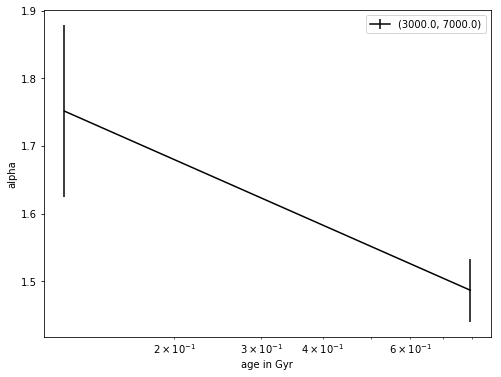

In [24]:


def colors(mini, maxi):
    cmin = {3000:'maroon',3500:'tomato',4000:'coral',
            4500:'gold',5000:'lime',5500:'darkgreen',
            6000: 'c',6500:'midnightblue'}
    if (mini==3000.) & (maxi==7000.):
        return 'black'
    elif (mini==3000.) & (maxi==4500.):
        return 'red'
    elif (mini==4500.) & (maxi==5500.):
        return 'orange'
    elif (mini==5500.) & (maxi==7000.):
        return 'green'
    else:
        return cmin[mini]
    
fig, ax = plt.subplots(figsize=(8,6))
for label, df in res.groupby(['Tmin','Tmax']):
    df.plot(x='age',y='alpha',yerr='alpha_err',
                 kind='line',logx=True, ax=ax,
                 markersize=100,
                 label=label, color=colors(label[0],label[1]))
    print(df[['minenerg','maxenerg','cluster','Tmin','Tmax']].sort_values(by='minenerg'))

plt.xlabel('age in Gyr')
plt.ylabel('alpha')
# plt.text(x=0.11,y=2.03,s='Pleiades')
# plt.text(x=0.14,y=2.0,s='NGC 1647')
# plt.text(x=0.7,y=1.95,s='Praesepe')
#plt.text(x=3.4,y=1.9,s='M67')
plt.legend()
#plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/dated/{}_alpha.jpg'.format(today),dpi=300)

### Plot beta(t)

3000.0


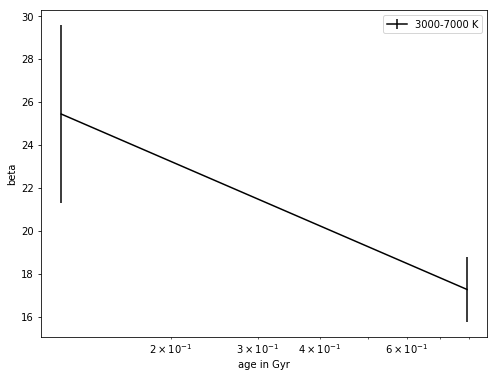

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in res.groupby(['Tmin','Tmax']):
    df.plot(x='age',y='beta',yerr='beta_err',
                 kind='line', ax=ax,
                 markersize=100,logx=True,
                 label='{:.0f}-{:.0f} K'.format(label[0],label[1]), color=colors(label[0],label[1]))
    print(label[0])
plt.xlabel('age in Gyr')
plt.ylabel('beta')
# plt.text(x=0.11,y=36,s='Pleiades')
# plt.text(x=0.14,y=34,s='NGC 1647')
# plt.text(x=0.7,y=38,s='Praesepe')
# plt.text(x=3.4,y=36,s='M67')
plt.legend()
plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/dated/{}_beta.jpg'.format(today),dpi=300)

### Plot total energy, total number of flares per cluster

In [28]:
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist')
locs2 = [#('NGC_1647','NGC_1647/results/run_{}/clusterenergies.csv'.format(run),.145),
         ('Pleiades','Pleiades/results/run_{}/clusterenergies.csv'.format(run),0.120),
         ('M44','M44/results/run_{}/clusterenergies.csv'.format(run),0.8),
         ('M67','M67/results/run_{}/clusterenergies.csv'.format(run),4.0)]
#Tlims = [(3000,4500,'red'),(4500,5500,'orange'),(5500,7000,'green'),(3000,7000,'black')]
Tlims = [(3000,7000,'black')]
dats = []
for Tmin, Tmax, color in Tlims:
    for (name, value, age) in locs2:
        df = pd.read_csv(value,
                         usecols = ['clustered','clusterederr','clusterenergy',
                                    'clusterenergy_err','rel_energ_err','Teff',
                                    'stars_in_bin','Tmin','Tmax','L_bol','L_bol_err'],
                         )
        #select color bin:
        df = df[(df.Tmin == Tmin) & (df.Tmax == Tmax)]
        #check if correct
        df = df.dropna(how='any')

        if (df.stars_in_bin != df.stars_in_bin.iloc[0]).any(): 
            raise ValueError('The number of stars in your bin is ambiguous.')
        #normalization constant
        n_stars = df.stars_in_bin.iloc[0]
        FAerr = np.sqrt( df.clusterenergy_err**2 + ( df.clusterenergy * df.L_bol_err /  df.L_bol )**2 ) /  df.L_bol
        dats.append([age, n_stars,
                    np.sqrt((df.clusterenergy_err**2).sum())/n_stars,
                    df.clusterenergy.sum()/n_stars, 
                    df.shape[0]/n_stars,
                    df.shape[0],
                    Tmin,Tmax,
                    (df.clusterenergy/df.L_bol).sum()/n_stars,
                     np.sqrt((FAerr**2).sum())/n_stars,
                    ]
                    )
dats = np.asarray(dats) 
data = pd.DataFrame(dats, columns=['age','n_stars',
                                   'tot_en_err','tot_en',
                                   'tot_flares_p_star','tot_flares',
                                   'Tmin','Tmax','FA_pstar','FA_pstar_err'])
data['tot_flares_p_star_err'] = np.sqrt(data.tot_flares_p_star)
data.sort_values(by='age').head()

,age,n_stars,tot_en_err,tot_en,tot_flares_p_star,tot_flares,Tmin,Tmax,FA_pstar,FA_pstar_err,tot_flares_p_star_err
0,0.12,155.0,1.649063e+32,3.664435e+33,2.690323,417.0,3000.0,7000.0,108.537183,18.424085,1.640220
1,0.80,87.0,2.800315e+32,6.035578e+33,3.068966,267.0,3000.0,7000.0,525.713743,81.206227,1.751846
2,4.00,65.0,3.724095e+31,4.329156e+32,0.292308,19.0,3000.0,7000.0,0.245406,0.048966,0.540655


3000.0


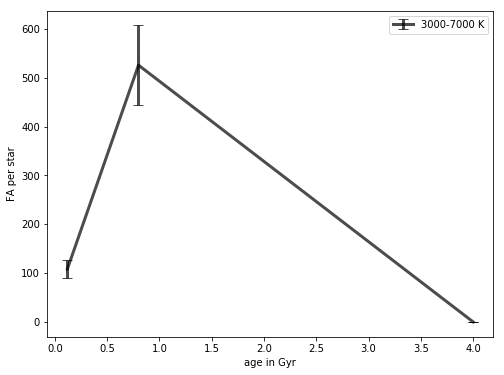

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in data.groupby(['Tmin','Tmax']):
    df = df.sort_values(by='age')
    df.plot(x='age',y='FA_pstar',yerr='FA_pstar_err',
                 kind='line', ax=ax,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,
                 label='{:.0f}-{:.0f} K'.format(label[0],label[1]), color=colors(label[0],label[1]))
    print(label[0])
plt.xlabel('age in Gyr')
plt.ylabel('FA per star')
# plt.text(x=0.11,y=2e32,s='Pleiades')
# plt.text(x=0.14,y=1e32,s='NGC 1647')
# plt.text(x=0.6,y=2e32,s='Praesepe')
# plt.text(x=3.4,y=4e32,s='M67')
plt.legend()
plt.savefig('share/dated/{}_tot_en_color_bins.jpg'.format(today),dpi=300)

3000.0


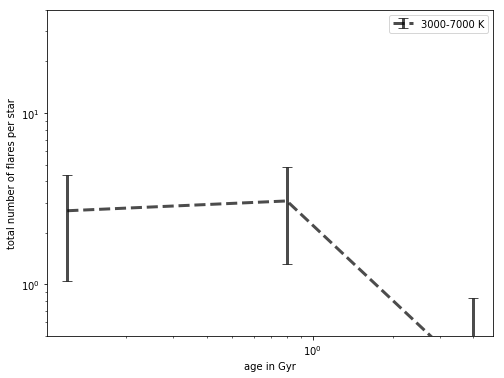

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in data.groupby(['Tmin','Tmax']):
    df = df.sort_values(by='age')
    df.plot(x='age',y='tot_flares_p_star',yerr='tot_flares_p_star_err',
                 kind='line', ax=ax,capsize=5,
                 markersize=50,loglog=True,alpha=0.7,
                linewidth=3,
                 linestyle='dashed',
                 label='{:.0f}-{:.0f} K'.format(label[0],label[1]), color=colors(label[0],label[1]))
    print(label[0])
plt.xlabel('age in Gyr')
plt.ylabel('total number of flares per star')
plt.ylim(5e-1,4e1)
# plt.text(x=0.11,y=30,s='Pleiades')
# plt.text(x=0.14,y=18,s='NGC 1647')
# plt.text(x=0.7,y=16,s='Praesepe')
# plt.text(x=3.55,y=2.5,s='M67')
plt.legend()
plt.savefig('share/dated/{}_tot_flares_color_bins.jpg'.format(today),dpi=300)